In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

djia_tickers = ["PC_Jeweller_c", "Rajesh_Exports_c","Goldiam_International_c","Muthoot_finance_c","Titan_c","Tribhovandas_Bhimji_Zaveri_c","thanga_mayil_c"]
start_date = "2016-01-01"
end_date = "2024-01-01"

def load_stock_data(ticker, start_date, end_date):
    try:
        df = pd.read_excel(f"{ticker}.xlsx")
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df.sort_index()
        mask = (df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))
        return df.loc[mask]
    except Exception as e:
        print(f"Error loading {ticker}: {e}")
        return None

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def prepare_lstm_data(series, look_back=12):
    X, y = [], []
    for i in range(len(series)-look_back-1):
        X.append(series[i:(i+look_back)])
        y.append(series[i+look_back])
    return np.array(X), np.array(y)

def plot_model_performance(history, ticker):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{ticker} - Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def plot_predictions_vs_actual(y_test, y_pred, ticker):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual Returns')
    plt.plot(y_pred, label='Predicted Returns')
    plt.title(f'{ticker} - Actual vs Predicted Returns')
    plt.ylabel('Returns')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

def get_expected_returns(returns):
    expected_returns = []
    for ticker in returns.columns:
        series = returns[ticker].values
        if len(series) < 15:
            expected_returns.append(np.mean(series))
            continue

        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(series.reshape(-1, 1))

        look_back = 12
        X, y = prepare_lstm_data(scaled_data, look_back)

        if len(X) < 10:
            expected_returns.append(np.mean(series))
            continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        X_train = X_train.reshape(X_train.shape[0], look_back, 1)
        X_test = X_test.reshape(X_test.shape[0], look_back, 1)

        model = create_lstm_model((look_back, 1))
        history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=6,
                          batch_size=100,
                          verbose=0)

        plot_model_performance(history, ticker)

        y_pred = model.predict(X_test)
        plot_predictions_vs_actual(y_test, y_pred, ticker)

        mse = mean_squared_error(y_test, y_pred)
        print(f"{ticker} - Test MSE: {mse:.6f}")

        if 'val_loss' in history.history:
            if history.history['val_loss'][-1] > history.history['loss'][-1]:
                print(f"Potential overfitting detected for {ticker}")
            else:
                print(f"No significant overfitting detected for {ticker}")

        predictions = []
        temp_data = scaled_data.copy()
        for _ in range(5):
            last_seq = temp_data[-look_back:]
            pred_scaled = model.predict(last_seq.reshape(1, look_back, 1))[0][0]
            pred = scaler.inverse_transform(np.array([[pred_scaled]]))[0][0]
            predictions.append(pred)
            temp_data = np.append(temp_data, [[pred_scaled]], axis=0)

        expected_return = np.mean(predictions)
        expected_returns.append(expected_return)
    return np.array(expected_returns)

def calculate_statistics(ticker, start_date, end_date):
    stock_data = load_stock_data(ticker, start_date, end_date)
    if stock_data is None or stock_data.empty:
        return None

    stock_data = stock_data.resample('W').last()
    stock_data['Weekly Return'] = stock_data['Close'].pct_change()
    stock_data.dropna(inplace=True)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(stock_data['Weekly Return'].values.reshape(-1, 1))

    look_back = 12
    if len(scaled_data) > look_back + 5:
        X, y = prepare_lstm_data(scaled_data, look_back)
        if len(X) > 10:
            model = create_lstm_model((look_back, 1))
            model.fit(X, y, epochs=6, batch_size=40, verbose=0)

            predictions = []
            temp_data = scaled_data.copy()
            for _ in range(5):
                last_seq = temp_data[-look_back:]
                pred_scaled = model.predict(last_seq.reshape(1, look_back, 1))[0][0]
                pred = scaler.inverse_transform(np.array([[pred_scaled]]))[0][0]
                predictions.append(pred)
                temp_data = np.append(temp_data, [[pred_scaled]], axis=0)

            expected_return = np.mean(predictions)
        else:
            expected_return = stock_data['Weekly Return'].mean()
    else:
        expected_return = stock_data['Weekly Return'].mean()

    return {
        'Stock': ticker,
        'Mean': stock_data['Weekly Return'].mean(),
        'DL Expected Return': expected_return,
        'Standard Deviation': stock_data['Weekly Return'].std(),
        'Skewness': stock_data['Weekly Return'].skew(),
        'Kurtosis': stock_data['Weekly Return'].kurtosis()
    }

data = []
for ticker in djia_tickers:
    try:
        stats = calculate_statistics(ticker, start_date, end_date)
        if stats is not None:
            data.append(stats)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

df = pd.DataFrame(data)
print(df)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
                          Stock      Mean  DL Expected Return  \
0                 PC_Jeweller_c  0.002360            0.034610   
1              Rajesh_Exports_c -0.000408           -0.001860   
2       Goldiam_International_c  0.009131            0.013196   
3             Muthoot_finance_c  0.006194            0.005678   
4                       Titan_c  0.006489            0.005318   
5  Tribhovandas_Bhimji_Zaveri_c  0.003384            0.008900   
6                thanga_mayil_c  0.008096            0.004649   

   Standard Deviation  Skewness   Kurtosis  
0            0.109821  1.666493  10.378164  
1            0.044463 -0.071471   2.868638  
2            0.073228  1.079986   3.222065  
3            0.048478  0.709746   3.947818  
4            0.041630  0.098368   2.919045  
5            0.074

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


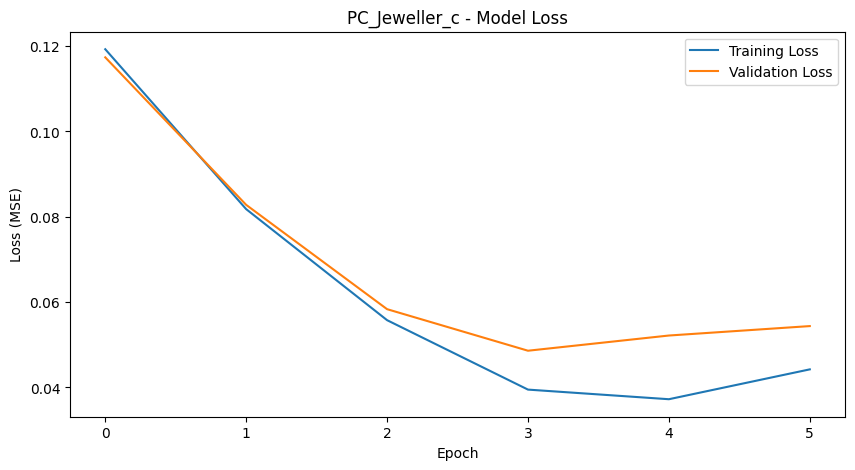

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


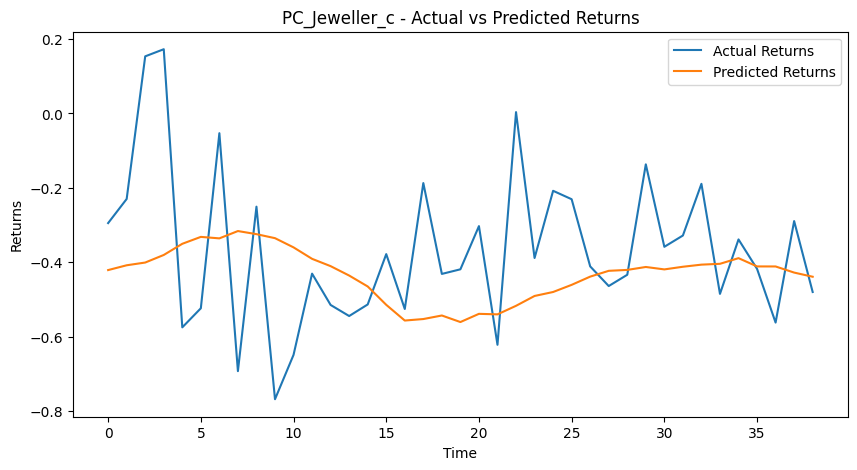

PC_Jeweller_c - Test MSE: 0.054377
Potential overfitting detected for PC_Jeweller_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


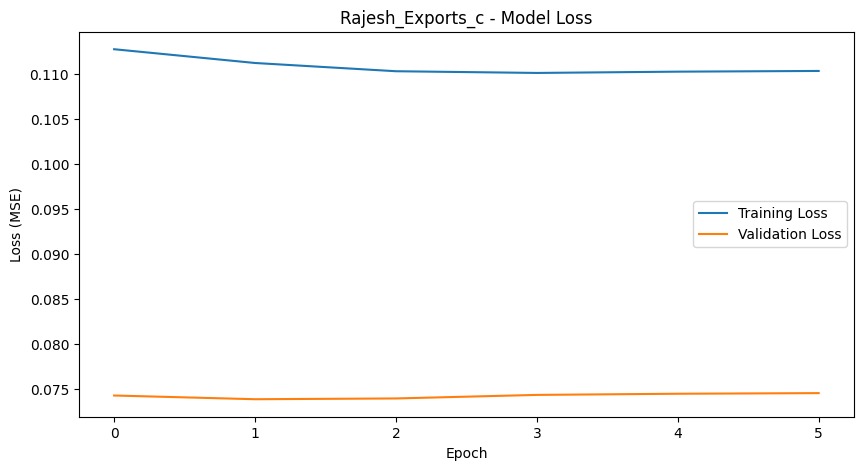

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


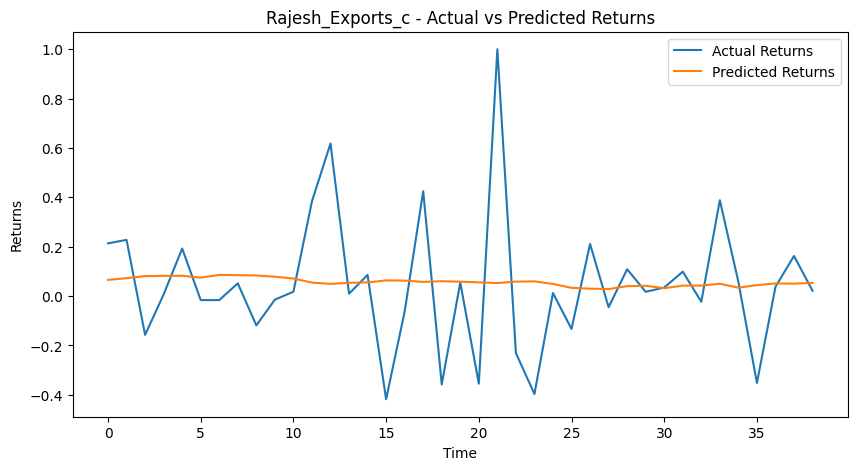

Rajesh_Exports_c - Test MSE: 0.074574
No significant overfitting detected for Rajesh_Exports_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


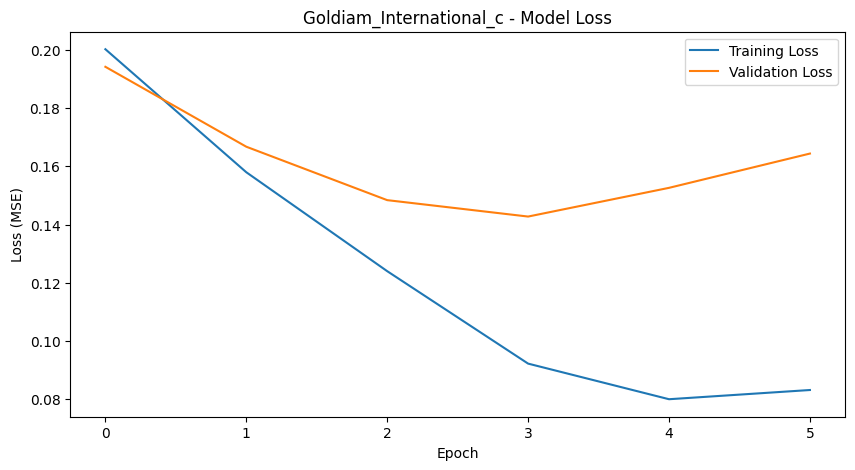

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


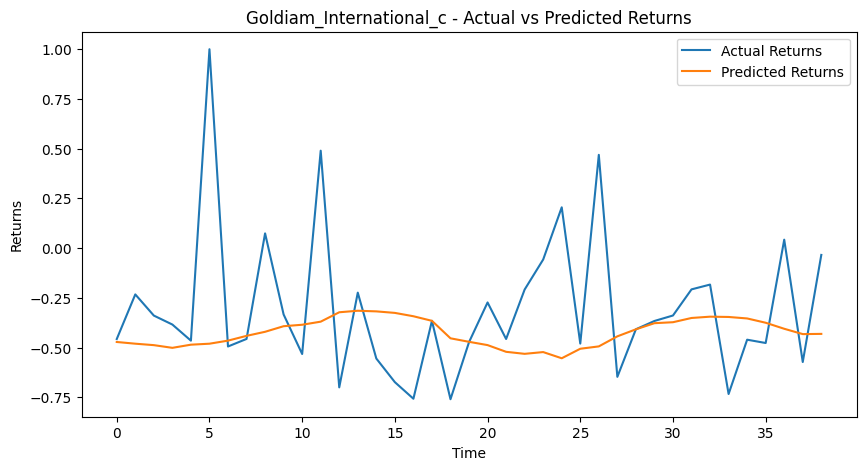

Goldiam_International_c - Test MSE: 0.164382
Potential overfitting detected for Goldiam_International_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


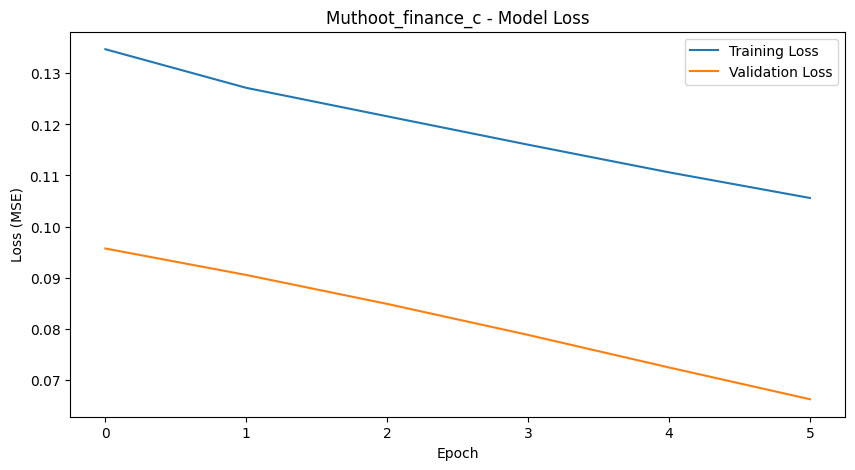

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


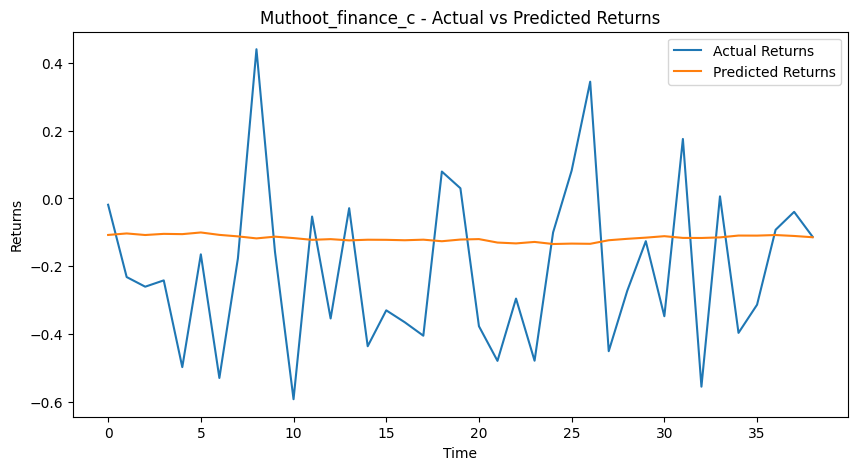

Muthoot_finance_c - Test MSE: 0.066213
No significant overfitting detected for Muthoot_finance_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


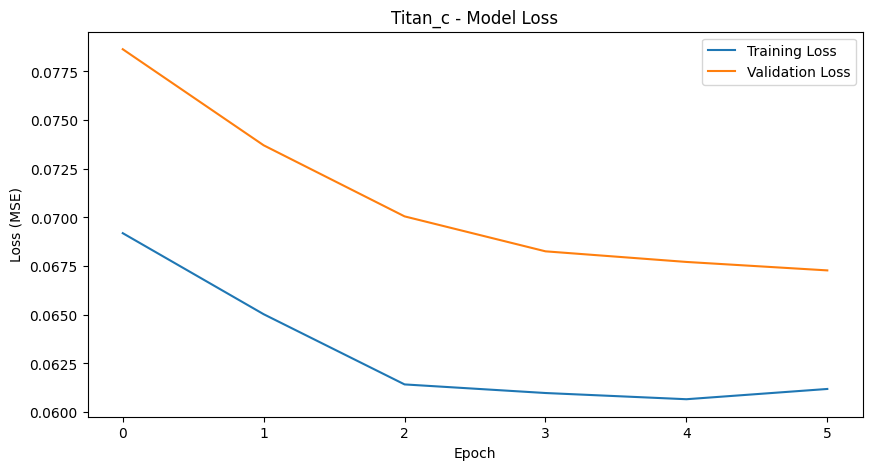

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


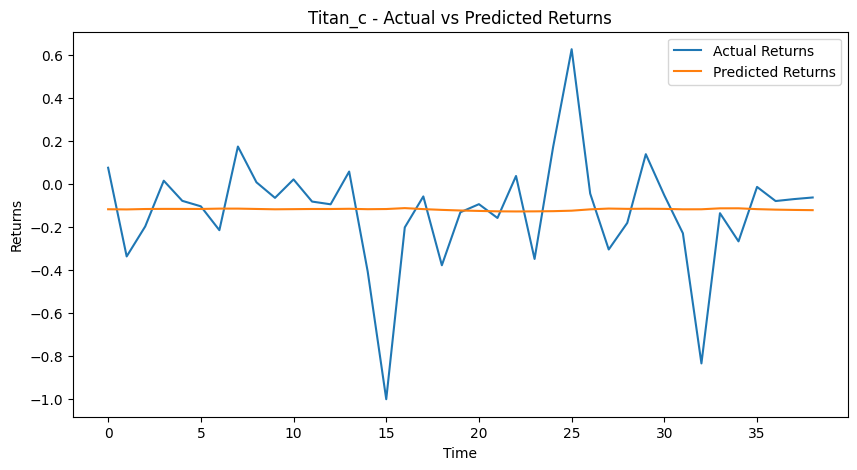

Titan_c - Test MSE: 0.067280
Potential overfitting detected for Titan_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


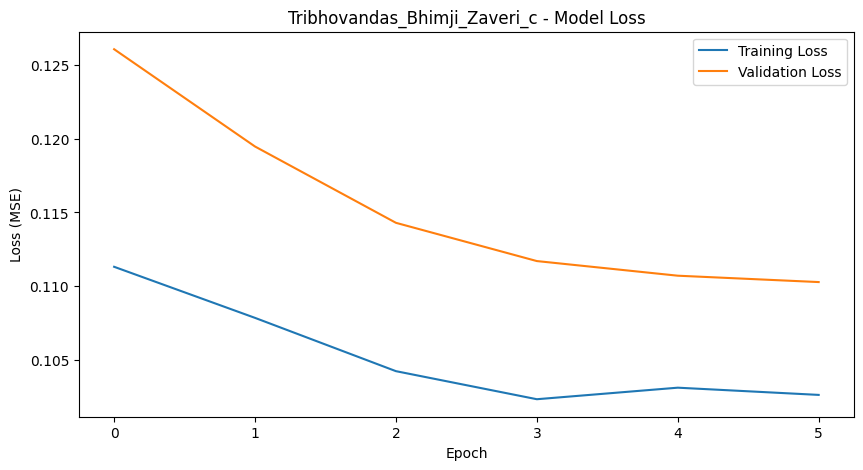

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


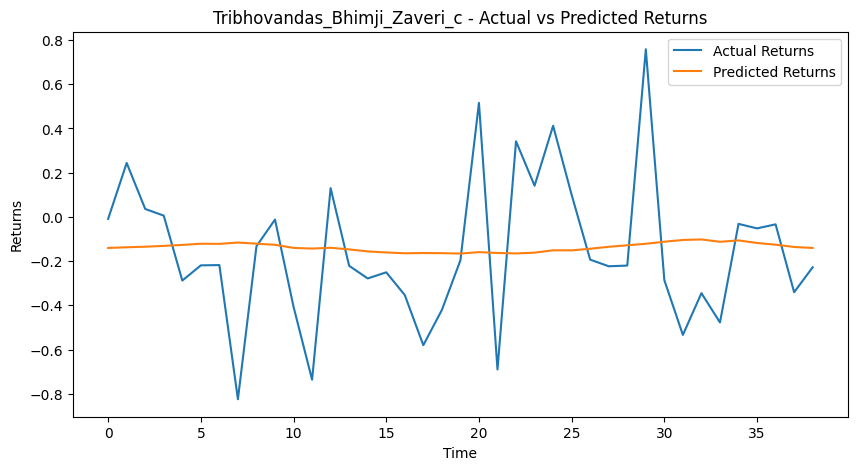

Tribhovandas_Bhimji_Zaveri_c - Test MSE: 0.110288
Potential overfitting detected for Tribhovandas_Bhimji_Zaveri_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


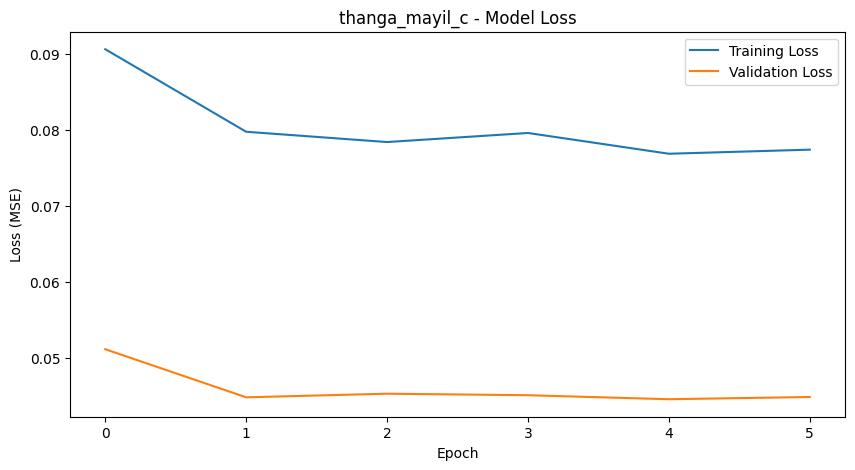

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step


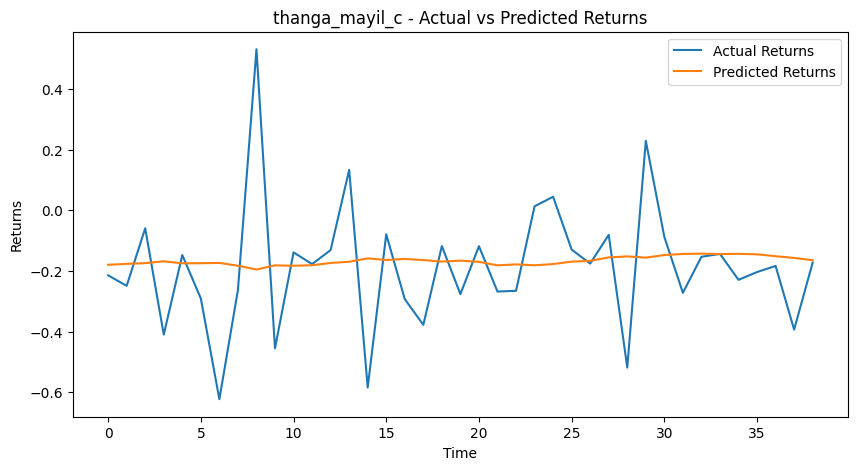

thanga_mayil_c - Test MSE: 0.044846
No significant overfitting detected for thanga_mayil_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


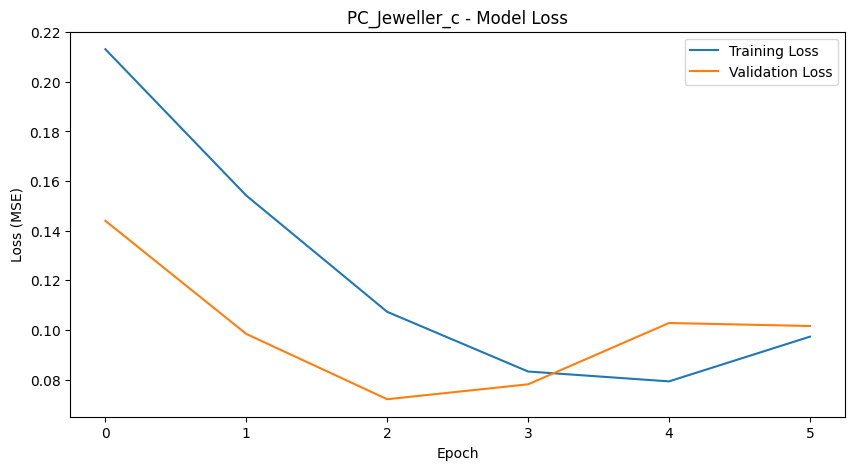

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


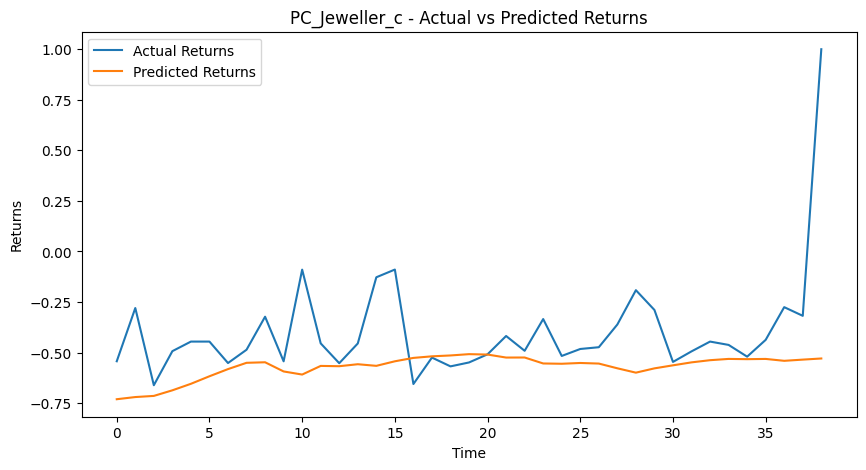

PC_Jeweller_c - Test MSE: 0.101611
Potential overfitting detected for PC_Jeweller_c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from scipy.optimize import minimize

d1_start = "2016-01-01"
d1_end = "2019-12-31"
d2_start = "2020-01-01"
d2_end = "2024-01-01"

def load_all_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for ticker in tickers:
        df = load_stock_data(ticker, start_date, end_date)
        if df is not None and not df.empty:
            data[ticker] = df['Close']
    return data

full_data = load_all_data(djia_tickers, d1_start, d2_end)
weekly_data = full_data.resample('W').last()

d1_data = weekly_data.loc[d1_start:d1_end]
d2_data = weekly_data.loc[d2_start:d2_end]

d1_returns = d1_data.pct_change().dropna()
d2_returns = d2_data.pct_change().dropna()

d1_expected_returns = get_expected_returns(d1_returns)
d2_expected_returns = get_expected_returns(d2_returns)

def absolute_deviation(weights, returns):
    portfolio_returns = np.dot(returns, weights)
    mean_portfolio_return = np.mean(portfolio_returns)
    return np.mean(np.abs(portfolio_returns - mean_portfolio_return))

def mean_return(weights, expected_returns):
    return np.dot(expected_returns, weights)

def constraint_target_return(weights, expected_returns, target_return):
    return np.dot(expected_returns, weights) - target_return

def constraint_sum_weights(weights):
    return np.sum(weights) - 1

def optimize_mad_portfolio(returns, expected_returns, target_return):
    n_assets = returns.shape[1]
    x0 = np.ones(n_assets) / n_assets

    constraints = (
        {'type': 'ineq', 'fun': constraint_target_return, 'args': (expected_returns, target_return)},
        {'type': 'eq', 'fun': constraint_sum_weights}
    )

    bounds = tuple((0, 1) for _ in range(n_assets))

    result = minimize(
        lambda w: absolute_deviation(w, returns),
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    return result.x

target_return = 0.002

d1_optimal_weights = optimize_mad_portfolio(d1_returns, d1_expected_returns, target_return)
d2_optimal_weights = optimize_mad_portfolio(d2_returns, d2_expected_returns, target_return)

portfolio_composition = pd.DataFrame({
    'Stock': djia_tickers,
    'Weights (%) [D1 Period]': d1_optimal_weights * 100,
    'Weights (%) [D2 Period]': d2_optimal_weights * 100
})

portfolio_composition['Ranking [D1 Period]'] = portfolio_composition['Weights (%) [D1 Period]'].rank(ascending=False)
portfolio_composition['Ranking [D2 Period]'] = portfolio_composition['Weights (%) [D2 Period]'].rank(ascending=False)

portfolio_composition['Weights (%) [D1 Period]'] = portfolio_composition['Weights (%) [D1 Period]'].apply(lambda x: f"{x:.4f}" if x > 0 else '-')
portfolio_composition['Weights (%) [D2 Period]'] = portfolio_composition['Weights (%) [D2 Period]'].apply(lambda x: f"{x:.4f}" if x > 0 else '-')
portfolio_composition['Ranking [D1 Period]'] = portfolio_composition['Ranking [D1 Period]'].apply(lambda x: f"{int(x)}" if x > 0 else '-')
portfolio_composition['Ranking [D2 Period]'] = portfolio_composition['Ranking [D2 Period]'].apply(lambda x: f"{int(x)}" if x > 0 else '-')

print("Optimal Portfolio Composition (MAD Model with DL Expected Returns):")
print(portfolio_composition[['Stock', 'Weights (%) [D1 Period]', 'Ranking [D1 Period]', 'Weights (%) [D2 Period]', 'Ranking [D2 Period]']])

def calculate_portfolio_metrics(weights, returns, expected_returns):
    mean_ret = mean_return(weights, expected_returns)
    abs_dev = absolute_deviation(weights, returns)
    perf_ratio = mean_ret / abs_dev
    return mean_ret, abs_dev, perf_ratio

d1_mean_ret, d1_abs_dev, d1_perf_ratio = calculate_portfolio_metrics(d1_optimal_weights, d1_returns, d1_expected_returns)
d2_mean_ret, d2_abs_dev, d2_perf_ratio = calculate_portfolio_metrics(d2_optimal_weights, d2_returns, d2_expected_returns)

print("\nPortfolio Metrics:")
print(f"D1 Period - Mean Return: {d1_mean_ret:.4f}, Absolute Deviation: {d1_abs_dev:.4f}, Performance Ratio: {d1_perf_ratio:.4f}")
print(f"D2 Period - Mean Return: {d2_mean_ret:.4f}, Absolute Deviation: {d2_abs_dev:.4f}, Performance Ratio: {d2_perf_ratio:.4f}")

def plot_cumulative_returns(returns, weights, title):
    plt.figure(figsize=(12, 6))

    for ticker in returns.columns:
        cum_returns = (1 + returns[ticker]).cumprod() - 1
        plt.plot(cum_returns, alpha=0.3)

    portfolio_returns = returns.dot(weights)
    cum_portfolio_returns = (1 + portfolio_returns).cumprod() - 1
    plt.plot(cum_portfolio_returns, linewidth=3, color='black', label='Portfolio')

    plt.title(title)
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

print("\nCumulative Returns Analysis:")
print("D1 Period:")
plot_cumulative_returns(d1_returns, d1_optimal_weights, "D1 Period - MAD Portfolio Cumulative Returns")


MADE Portfolio Composition with Deep Learning Expected Returns:
                          Stock Weights (%) [D1 Period] Ranking [D1 Period]  \
0                 PC_Jeweller_c                  0.0077                   7   
1              Rajesh_Exports_c                 29.3143                   2   
2       Goldiam_International_c                  2.3567                   6   
3             Muthoot_finance_c                 32.7103                   1   
4                       Titan_c                 21.7019                   3   
5  Tribhovandas_Bhimji_Zaveri_c                  3.2817                   5   
6                thanga_mayil_c                 10.6276                   4   

  Weights (%) [D2 Period] Ranking [D2 Period]  
0                  3.2738                   5  
1                 15.3083                   4  
2                 22.9682                   3  
3                 25.0894                   2  
4                 32.6001                   1  
5             

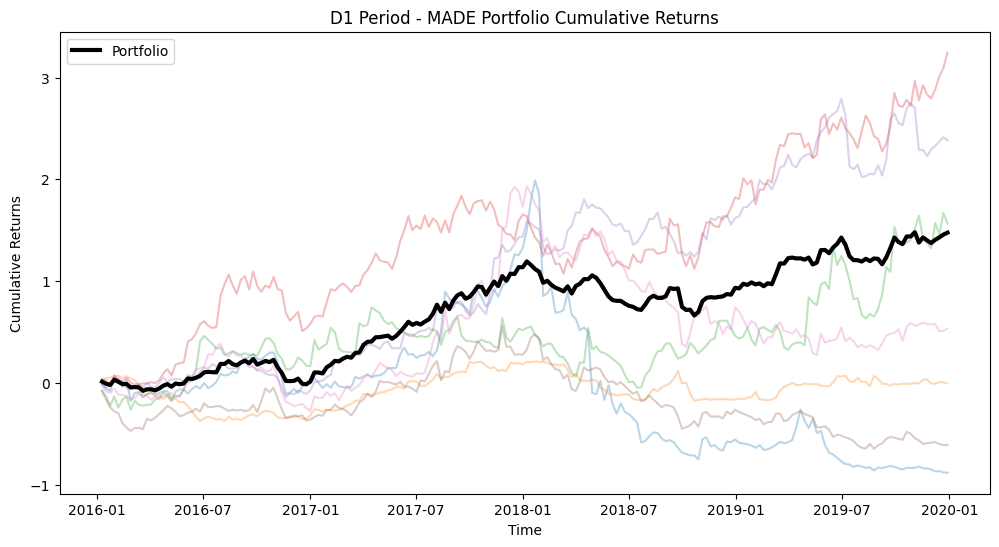


D2 Period Cumulative Returns:


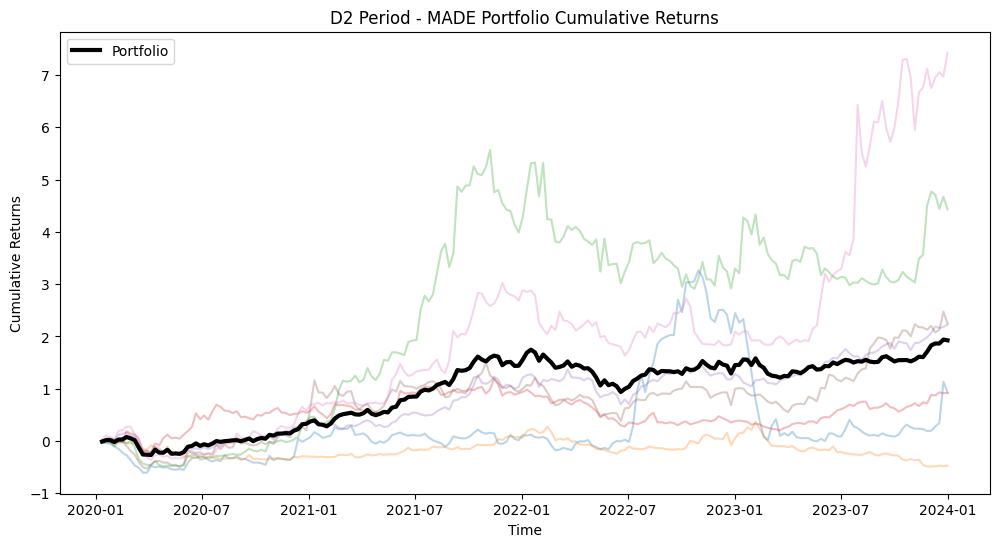


Portfolio Weight Distribution Analysis:
D1 Period:


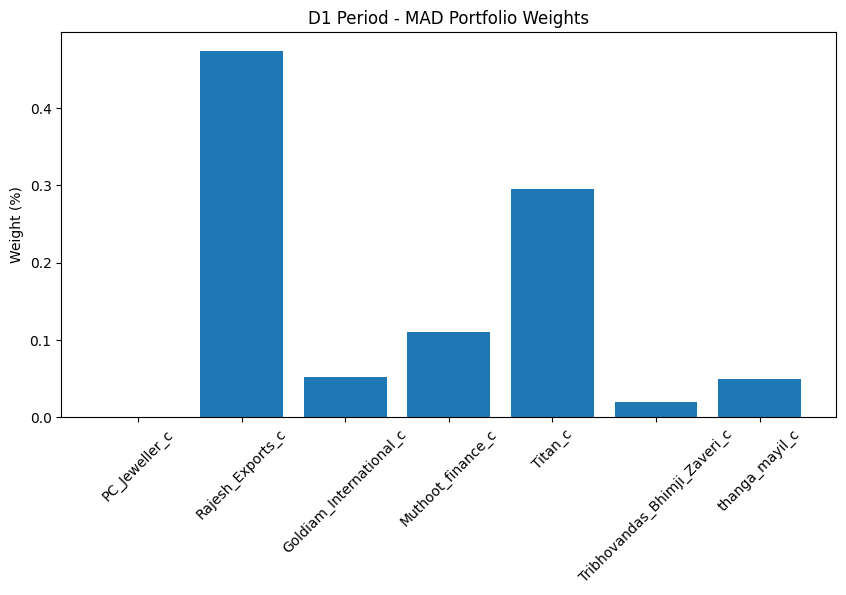

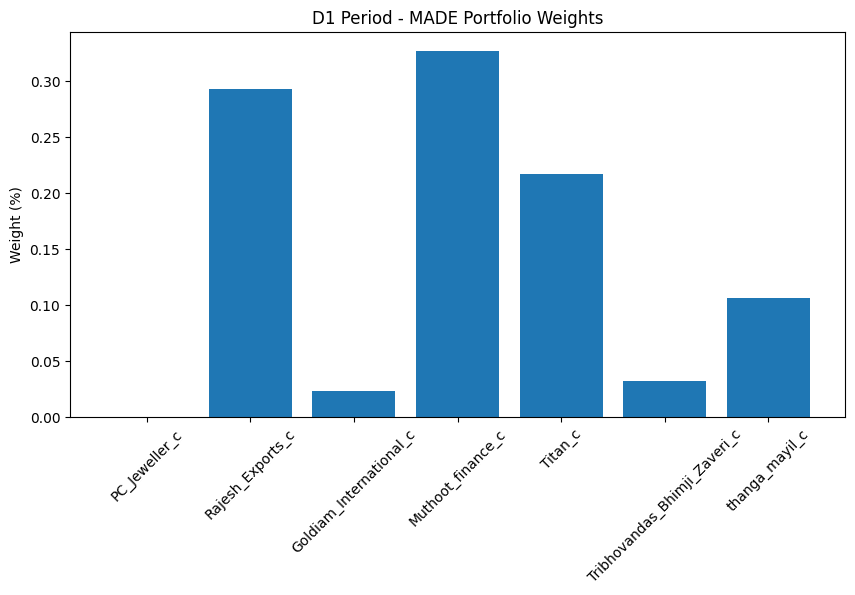


D2 Period:


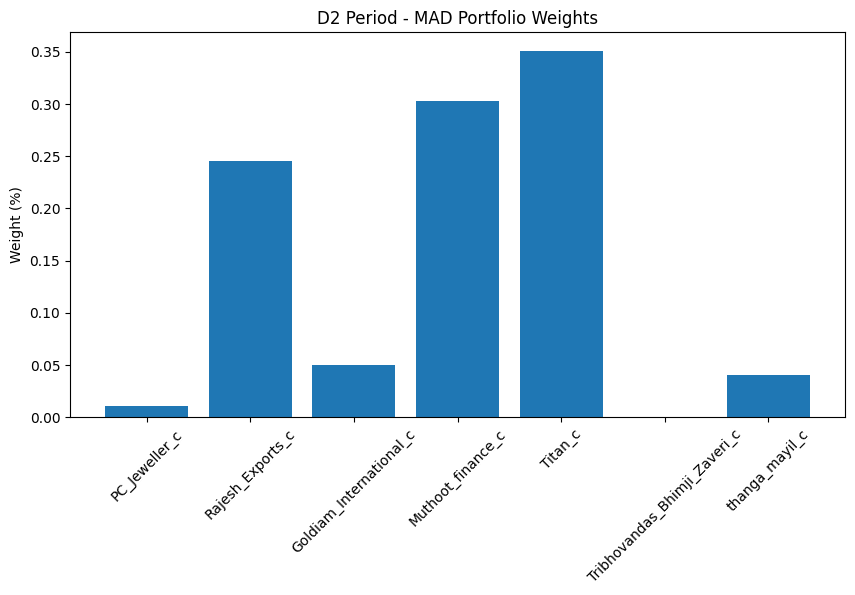

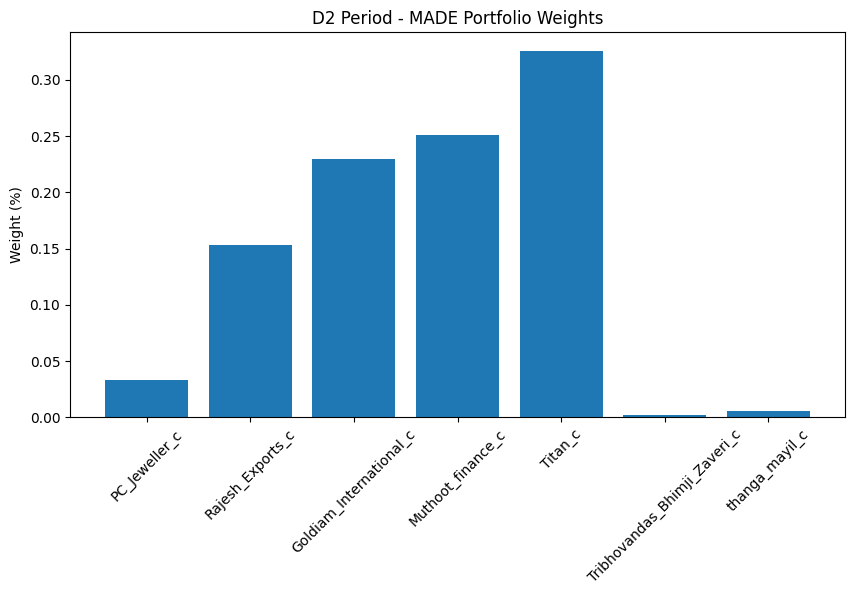

In [ ]:
def entropy(weights):
    return -np.sum(weights * np.log(weights + 1e-10))

def goal_programming_objective(weights, returns, expected_returns, R_star, W_star, max_entropy, alpha=1, beta=1, gamma=1):
    R = mean_return(weights, expected_returns)
    W = absolute_deviation(weights, returns)
    H = entropy(weights)

    d1 = np.abs(R - R_star)
    d2 = np.abs(W - W_star)
    d3 = np.abs(H - max_entropy)

    return alpha * (d1 / R_star) + beta * (d2 / W_star) + gamma * (d3 / max_entropy)

def optimize_made_portfolio(returns, expected_returns, alpha=1, beta=1, gamma=1):
    n_assets = returns.shape[1]

    res_R = minimize(
        lambda w: -mean_return(w, expected_returns),
        x0=np.ones(n_assets) / n_assets,
        method='SLSQP',
        bounds=tuple((0, 1) for _ in range(n_assets)),
        constraints=({'type': 'eq', 'fun': constraint_sum_weights})
    )
    R_star = -res_R.fun

    res_W = minimize(
        lambda w: absolute_deviation(w, returns),
        x0=np.ones(n_assets) / n_assets,
        method='SLSQP',
        bounds=tuple((0, 1) for _ in range(n_assets)),
        constraints=({'type': 'eq', 'fun': constraint_sum_weights})
    )
    W_star = res_W.fun

    max_entropy = np.log(n_assets)

    res = minimize(
        lambda w: goal_programming_objective(w, returns, expected_returns, R_star, W_star, max_entropy, alpha, beta, gamma),
        x0=np.ones(n_assets) / n_assets,
        method='SLSQP',
        bounds=tuple((0, 1) for _ in range(n_assets)),
        constraints=({'type': 'eq', 'fun': constraint_sum_weights})
    )

    return res.x, R_star, W_star, max_entropy

d1_made_weights, d1_R_star, d1_W_star, d1_max_entropy = optimize_made_portfolio(d1_returns, d1_expected_returns)
d2_made_weights, d2_R_star, d2_W_star, d2_max_entropy = optimize_made_portfolio(d2_returns, d2_expected_returns)

made_composition = pd.DataFrame({
    'Stock': djia_tickers,
    'Weights (%) [D1 Period]': d1_made_weights * 100,
    'Weights (%) [D2 Period]': d2_made_weights * 100
})

made_composition['Ranking [D1 Period]'] = made_composition['Weights (%) [D1 Period]'].rank(ascending=False)
made_composition['Ranking [D2 Period]'] = made_composition['Weights (%) [D2 Period]'].rank(ascending=False)

made_composition['Weights (%) [D1 Period]'] = made_composition['Weights (%) [D1 Period]'].apply(lambda x: f"{x:.4f}" if x > 0 else '-')
made_composition['Weights (%) [D2 Period]'] = made_composition['Weights (%) [D2 Period]'].apply(lambda x: f"{x:.4f}" if x > 0 else '-')
made_composition['Ranking [D1 Period]'] = made_composition['Ranking [D1 Period]'].apply(lambda x: f"{int(x)}" if x > 0 else '-')
made_composition['Ranking [D2 Period]'] = made_composition['Ranking [D2 Period]'].apply(lambda x: f"{int(x)}" if x > 0 else '-')

print("\nMADE Portfolio Composition with Deep Learning Expected Returns:")
print(made_composition[['Stock', 'Weights (%) [D1 Period]', 'Ranking [D1 Period]', 'Weights (%) [D2 Period]', 'Ranking [D2 Period]']])

d1_made_mean, d1_made_abs_dev, d1_made_perf_ratio = calculate_portfolio_metrics(d1_made_weights, d1_returns, d1_expected_returns)
d2_made_mean, d2_made_abs_dev, d2_made_perf_ratio = calculate_portfolio_metrics(d2_made_weights, d2_returns, d2_expected_returns)

print("\nMADE Portfolio Metrics:")
print(f"D1 Period - Mean Return: {d1_made_mean:.4f}, Absolute Deviation: {d1_made_abs_dev:.4f}, Performance Ratio: {d1_made_perf_ratio:.4f}")
print(f"D2 Period - Mean Return: {d2_made_mean:.4f}, Absolute Deviation: {d2_made_abs_dev:.4f}, Performance Ratio: {d2_made_perf_ratio:.4f}")

print("\nD1 Period Cumulative Returns:")
plot_cumulative_returns(d1_returns, d1_made_weights, "D1 Period - MADE Portfolio Cumulative Returns")
print("\nD2 Period Cumulative Returns:")
plot_cumulative_returns(d2_returns, d2_made_weights, "D2 Period - MADE Portfolio Cumulative Returns")

def plot_weight_distribution(weights, tickers, title):
    plt.figure(figsize=(10, 5))
    plt.bar(tickers, weights)
    plt.title(title)
    plt.ylabel('Weight (%)')
    plt.xticks(rotation=45)
    plt.show()

print("\nPortfolio Weight Distribution Analysis:")
print("D1 Period:")
plot_weight_distribution(d1_optimal_weights, djia_tickers, "D1 Period - MAD Portfolio Weights")
plot_weight_distribution(d1_made_weights, djia_tickers, "D1 Period - MADE Portfolio Weights")
print("\nD2 Period:")
plot_weight_distribution(d2_optimal_weights, djia_tickers, "D2 Period - MAD Portfolio Weights")
plot_weight_distribution(d2_made_weights, djia_tickers, "D2 Period - MADE Portfolio Weights")


Naive Diversification Results:
D1 Period - Mean Return: -0.0100, Absolute Deviation: 0.0277, Performance Ratio: -0.3619
D2 Period - Mean Return: -0.0088, Absolute Deviation: 0.0301, Performance Ratio: -0.2924

Comparison of All Approaches:
D1 Period:
MAD Model - Performance Ratio: 0.2051
MADE Model - Performance Ratio: 0.4102
Naive Diversification - Performance Ratio: -0.3619

D2 Period:
MAD Model - Performance Ratio: 0.0852
MADE Model - Performance Ratio: 0.2453
Naive Diversification - Performance Ratio: -0.2924


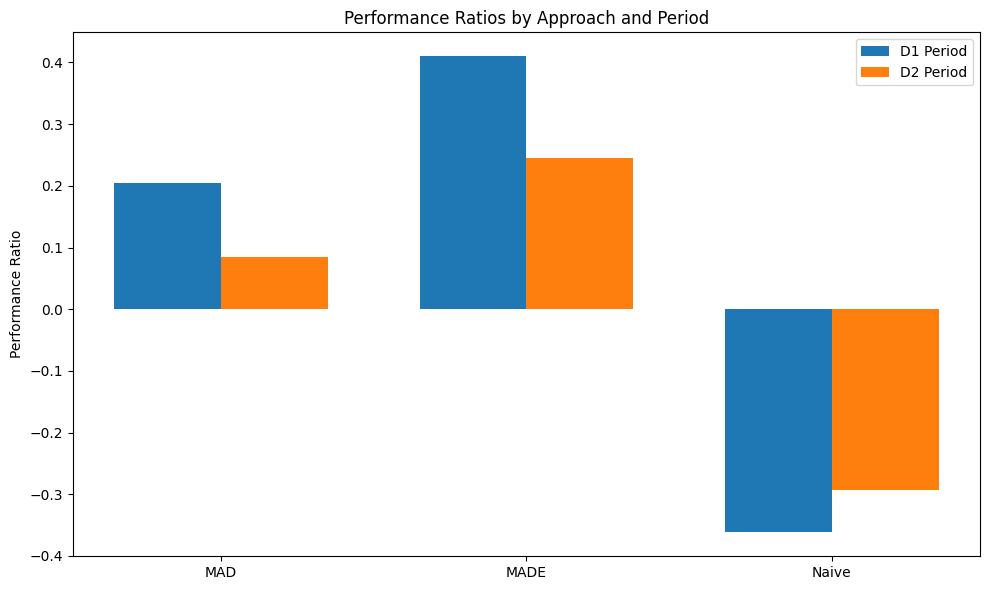

In [ ]:
def performance_ratio(mean_return, absolute_deviation):
    return mean_return / absolute_deviation

d1_performance_ratio = performance_ratio(d1_R_star, d1_W_star)
d2_performance_ratio = performance_ratio(d2_R_star, d2_W_star)

def naive_diversification(returns):
    n_assets = returns.shape[1]
    weights = np.ones(n_assets) / n_assets
    return weights

def calculate_naive_metrics(returns, expected_returns):
    weights = naive_diversification(returns)
    mean_ret = mean_return(weights, expected_returns)
    abs_dev = absolute_deviation(weights, returns)
    perf_ratio = performance_ratio(mean_ret, abs_dev)
    return mean_ret, abs_dev, perf_ratio

d1_naive_mean, d1_naive_abs_dev, d1_naive_perf_ratio = calculate_naive_metrics(d1_returns, d1_expected_returns)
d2_naive_mean, d2_naive_abs_dev, d2_naive_perf_ratio = calculate_naive_metrics(d2_returns, d2_expected_returns)

print("\nNaive Diversification Results:")
print(f"D1 Period - Mean Return: {d1_naive_mean:.4f}, Absolute Deviation: {d1_naive_abs_dev:.4f}, Performance Ratio: {d1_naive_perf_ratio:.4f}")
print(f"D2 Period - Mean Return: {d2_naive_mean:.4f}, Absolute Deviation: {d2_naive_abs_dev:.4f}, Performance Ratio: {d2_naive_perf_ratio:.4f}")

print("\nComparison of All Approaches:")
print("D1 Period:")
print(f"MAD Model - Performance Ratio: {d1_perf_ratio:.4f}")
print(f"MADE Model - Performance Ratio: {d1_made_perf_ratio:.4f}")
print(f"Naive Diversification - Performance Ratio: {d1_naive_perf_ratio:.4f}")

print("\nD2 Period:")
print(f"MAD Model - Performance Ratio: {d2_perf_ratio:.4f}")
print(f"MADE Model - Performance Ratio: {d2_made_perf_ratio:.4f}")
print(f"Naive Diversification - Performance Ratio: {d2_naive_perf_ratio:.4f}")

def plot_all_performance_ratios(d1_ratios, d2_ratios, labels):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, d1_ratios, width, label='D1 Period')
    rects2 = ax.bar(x + width/2, d2_ratios, width, label='D2 Period')

    ax.set_ylabel('Performance Ratio')
    ax.set_title('Performance Ratios by Approach and Period')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

d1_ratios = [d1_perf_ratio, d1_made_perf_ratio, d1_naive_perf_ratio]
d2_ratios = [d2_perf_ratio, d2_made_perf_ratio, d2_naive_perf_ratio]
labels = ['MAD', 'MADE', 'Naive']

plot_all_performance_ratios(d1_ratios, d2_ratios, labels)